In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
plt.style.use('dark_background')

from scipy import sparse
from scipy.sparse.linalg import spsolve

import warnings
warnings.filterwarnings('ignore')

import nbimporter
from FEM import Mesh

In [2]:
class FEM_Heat():
    def __init__(self, nodes_dict, elems_dict, K):
        self.nodes_dict = nodes_dict         # node_ID : (x, y, z)
        self.elems_dict = elems_dict         # elem_ID : (n1, n2, n3)
        self.k = K                           # Thermal conductivity

        self.n_nodes = len(self.nodes_dict)
        self.n_elems = len(self.elems_dict)

        self.n_dofs = self.n_nodes
        self.dofs_mapping = {}               # elem_ID : (dof_1, dof_2, dof_3)
        self.all_dofs = np.arange(self.n_dofs)
        self.fixed_dofs = []

        self.global_K = None                 # Global stiffness matrix
        self.global_M = None                 # Global mass matrix
        self.T = np.zeros(self.n_dofs)       # Node temperatures
        self.Q = np.zeros(self.n_dofs)       # Heat fluxes at nodes

    def map_dofs(self):
        for elem_ID in list(self.elems_dict.keys()):
            elem_dofs = [node_ID - 1 for node_ID in self.elems_dict[elem_ID]]
            self.dofs_mapping[elem_ID] = elem_dofs

    def elem_area(self, elem_ID):
        node_1, node_2, node_3 = tuple(self.elems_dict[elem_ID])
        x1 = self.nodes_dict[node_1][0]
        x2 = self.nodes_dict[node_2][0]
        x3 = self.nodes_dict[node_3][0]
        y1 = self.nodes_dict[node_1][1]
        y2 = self.nodes_dict[node_2][1]
        y3 = self.nodes_dict[node_3][1]

        vector_prod = np.array([
            [x2 - x1, y2 - y1],
            [x3 - x1, y3 - y1]
        ])

        area = 0.5 * np.abs(np.linalg.det(vector_prod))

        return area

    def local_K(self, elem_ID):
        node_1, node_2, node_3 = tuple(self.elems_dict[elem_ID])
        x1 = self.nodes_dict[node_1][0]
        x2 = self.nodes_dict[node_2][0]
        x3 = self.nodes_dict[node_3][0]
        y1 = self.nodes_dict[node_1][1]
        y2 = self.nodes_dict[node_2][1]
        y3 = self.nodes_dict[node_3][1]

        # Ni = (alpha_i + beta_i * X + gamma_i * Y) / (2*area)
        # Matrix of equation system on shape functions
        matr = np.array([
            [1, x1, y1],
            [1, x2, y2],
            [1, x3, y3]
        ])

        # Shape functions coefs (alpha, beta, gamma)
        coefs = []
        for i in range(3):
            rhs = np.zeros(3)
            rhs[i] = 1
            coefs.append(np.linalg.solve(matr, rhs))

        area = self.elem_area(elem_ID)

        K = np.zeros((3,3))
        for i in range(3):
            for j in range(3):
                K[i][j] = self.k * (coefs[i][1]*coefs[j][1] + coefs[i][2]*coefs[j][2]) / (4*area)

        return K

    def integrate_SF(self, coords_x, coords_y, coefs_1, coefs_2, curr_split, max_split):
        x1 = coords_x[0]
        x2 = coords_x[1]
        x3 = coords_x[2]
        
        y1 = coords_y[0]
        y2 = coords_y[1]
        y3 = coords_y[2]
        
        mc_x = (x1 + x2 + x3)/3  # Mass center x
        mc_y = (y1 + y2 + y3)/3  # Mass center y

        if (curr_split == max_split):
            vector_prod = np.array([
                [x2 - x1, y2 - y1],
                [x3 - x1, y3 - y1]
            ])
    
            area = 0.5 * np.abs(np.linalg.det(vector_prod))
            
            value = (coefs_1[0] + coefs_1[1]*mc_x + coefs_1[2]*mc_y) * (coefs_2[0] + coefs_2[1]*mc_x + coefs_2[2]*mc_y) * area
            return value

        else:
            val_1 = self.integrate_SF([x1, x2, mc_x], [y1, y2, mc_y], coefs_1, coefs_2, curr_split + 1, max_split)
            val_2 = self.integrate_SF([x1, x3, mc_x], [y1, y3, mc_y], coefs_1, coefs_2, curr_split + 1, max_split)
            val_3 = self.integrate_SF([x2, x3, mc_x], [y2, y3, mc_y], coefs_1, coefs_2, curr_split + 1, max_split)
            return (val_1 + val_2 + val_3)
    
    def local_M(self, elem_ID):
        node_1, node_2, node_3 = tuple(self.elems_dict[elem_ID])
        x1 = self.nodes_dict[node_1][0]
        x2 = self.nodes_dict[node_2][0]
        x3 = self.nodes_dict[node_3][0]
        y1 = self.nodes_dict[node_1][1]
        y2 = self.nodes_dict[node_2][1]
        y3 = self.nodes_dict[node_3][1]

        # Ni = (alpha_i + beta_i * X + gamma_i * Y) / (2*area)
        # Matrix of equation system on shape functions
        matr = np.array([
            [1, x1, y1],
            [1, x2, y2],
            [1, x3, y3]
        ])
        
        # Shape functions coefs (alpha, beta, gamma)
        coefs = []
        for i in range(3):
            rhs = np.zeros(3)
            rhs[i] = 1
            coefs.append(np.linalg.solve(matr, rhs))

        M = np.zeros((3,3))
        for i in range(3):
            for j in range(3):
                M[i][j] = self.integrate_SF([x1, x2, x3], [y1, y2, y3], coefs[i], coefs[j], 1, 3)

        return M

    def assemble_K_M(self):
        global_iK = np.zeros(9 * self.n_elems)
        global_jK = np.zeros(9 * self.n_elems)
        global_aK = np.zeros(9 * self.n_elems)
        global_aM = np.zeros(9 * self.n_elems)
        
        for ei, elem in enumerate(list(self.elems_dict.keys())):
            iK = np.kron(self.dofs_mapping[elem], np.ones(3))
            jK = np.reshape(np.kron(self.dofs_mapping[elem], np.reshape(np.ones(3), (3,1))), -1)
            aK = np.reshape(self.local_K(elem), -1)
            aM = np.reshape(self.local_M(elem), -1)
            
            global_iK[9*ei : 9*(ei+1)] = iK
            global_jK[9*ei : 9*(ei+1)] = jK
            global_aK[9*ei : 9*(ei+1)] = aK
            global_aM[9*ei : 9*(ei+1)] = aM
            
        self.global_K = sparse.coo_matrix((global_aK,(global_iK, global_jK)),shape = (self.n_dofs, self.n_dofs)).tocsr()
        self.global_M = sparse.coo_matrix((global_aM,(global_iK, global_jK)),shape = (self.n_dofs, self.n_dofs)).tocsr()

    def solve_T(self):
        free_dofs = np.setdiff1d(self.all_dofs, self.fixed_dofs)
        self.T[free_dofs] = spsolve(self.global_K[free_dofs, :][:, free_dofs], self.Q[free_dofs])
        
        return self.T

    def set_temp(self, node_ID, temp):
        node_ID -= 1
        self.T[node_ID] = temp
        self.fixed_dofs.append(node_ID)

    def set_flux(self, node_ID, flux):
        node_ID -= 1
        self.Q[node_ID] += flux

    def visualize(self, cmap_, edges, figsize, data):
        Xs = []
        Ys = []
        Tris = []
        for node_id in list(self.nodes_dict.keys()):
            Xs.append(self.nodes_dict[node_id][0])
            Ys.append(self.nodes_dict[node_id][1])
        
        for elem_id in list(self.elems_dict.keys()):
            Tris.append(list(map(lambda x: x-1, self.elems_dict[elem_id])))

        Tris = np.array(Tris)
        mesh = matplotlib.tri.Triangulation(Xs, Ys, Tris)

        fig, axes = plt.subplots(figsize = figsize)

        axes.set_title('Temperature distribution')
        pos = axes.tripcolor(mesh, data, cmap = cmap_, edgecolors = edges, shading = 'flat')
        cbar = fig.colorbar(pos, ax = axes, shrink = 0.6)
        cbar.minorticks_on()

    # Considering that initial distribution is already set
    def dynamics(self, n_iter, time_step):
        self.Ts = [self.solve_T()]
        free_dofs = np.setdiff1d(self.all_dofs, self.fixed_dofs)
        
        for i in range(n_iter):
            T_old = self.Ts[-1][free_dofs]
            T_new = self.T

            M = self.global_M[free_dofs, :][:, free_dofs]
            M_inv = sparse.linalg.inv(M)
            
            term_1 = time_step * (self.Q[free_dofs] - self.global_K[free_dofs, :][:, free_dofs].dot(T_old))
            term_2 = M.dot(T_old)
            T_new[free_dofs] = M_inv.dot(term_2 + term_1)

            self.Ts.append(np.array(T_new))

        return self.Ts

In [3]:
eps = 1e-6

def mesh_bounds(mesh):
    node_IDs_upper = []
    node_IDs_bottom = []
    node_IDs_left = []
    node_IDs_right = []
    
    for node_id in list(mesh.nodes_dict.keys()):
        node_y = mesh.nodes_dict[node_id][1]
        node_x = mesh.nodes_dict[node_id][0]
        if abs(node_y - mesh.max_y) < eps:
            node_IDs_upper.append(node_id)
            
        if abs(node_y - mesh.min_y) < eps:
            node_IDs_bottom.append(node_id)
            
        if abs(node_x - mesh.min_x) < eps:
            node_IDs_left.append(node_id)
            
        if abs(node_x - mesh.max_x) < eps:
            node_IDs_right.append(node_id)
            
    return node_IDs_upper, node_IDs_bottom, node_IDs_left, node_IDs_right

In [4]:
mesh = Mesh()
mesh.read_mesh('New_Mesh')

mesh_nodes, mesh_elems = mesh.get_mesh()

Mesh from [New_Mesh] loaded.

Nodes: 		98
Elements: 	162


In [5]:
fem_solver = FEM_Heat(mesh_nodes, mesh_elems, 0.05)

In [6]:
fem_solver.map_dofs()

In [7]:
fem_solver.assemble_K_M()

In [8]:
upper, bottom, left, right = mesh_bounds(mesh)

In [9]:
for node in bottom:
    fem_solver.set_flux(node, 1000)

for node in upper:
    fem_solver.set_temp(node, 10)

In [10]:
n_iters = 20
delta_t = 1

In [11]:
ts = fem_solver.dynamics(n_iters, delta_t)

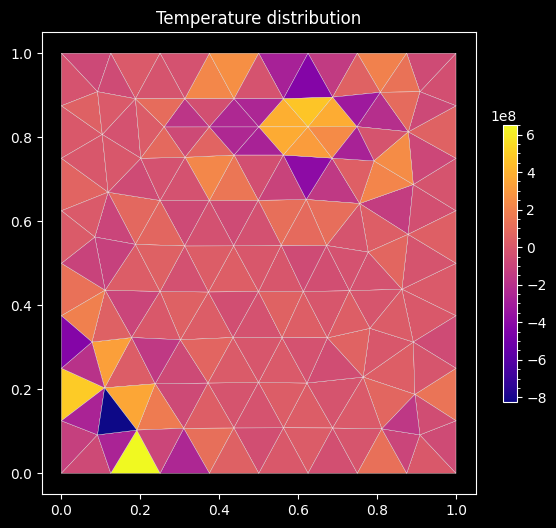

In [16]:
fem_solver.visualize('plasma', 'white', (7,6), ts[4])